In [1]:
import _init_paths
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import argparse
import pickle
import time
import sys
import ot
import os
# import ot
import cv2
import datetime

from load_data import *
from pytorch_models import *

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.optim import lr_scheduler

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict
import numpy as np


def summary(model, input_size, batch_size=-1, device="cuda"):
    outString = ""
    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    outString += "{}\n".format("----------------------------------------------------------------")
    # print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    outString += "{}\n".format(line_new)
    # print(line_new)
    outString += "{}\n".format("================================================================")
    # print("================================================================")
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        outString += "{}\n".format(line_new)
        # print(line_new)

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size

    outString += "{}\n".format("================================================================")
    # print("================================================================")
    outString += "{}\n".format("Total params: {0:,}".format(total_params))
    # print("Total params: {0:,}".format(total_params))
    outString += "{}\n".format("Trainable params: {0:,}".format(trainable_params))
    # print("Trainable params: {0:,}".format(trainable_params))
    outString += "{}\n".format("Non-trainable params: {0:,}".format(total_params - trainable_params))
    # print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    outString += "{}\n".format("----------------------------------------------------------------")
    # print("----------------------------------------------------------------")
    outString += "{}\n".format("Input size (MB): %0.2f" % total_input_size)
    # print("Input size (MB): %0.2f" % total_input_size)
    outString += "{}\n".format("Forward/backward pass size (MB): %0.2f" % total_output_size)
    # print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    outString += "{}\n".format("Params size (MB): %0.2f" % total_params_size)
    # print("Params size (MB): %0.2f" % total_params_size)
    outString += "{}\n".format("Estimated Total Size (MB): %0.2f" % total_size)
    # print("Estimated Total Size (MB): %0.2f" % total_size)
    outString += "{}\n".format("----------------------------------------------------------------")
    # print("----------------------------------------------------------------")
    # return summary
    # print("outString : {}".format(outString))
    return outString

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, attention=False):
        super().__init__()
        self.attention = attention
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            # nn.ReLU(inplace=True)
            nn.LeakyReLU(0.2, True),
        )
        self.se = SEModule(out_channels)

    def forward(self, x):
        out = self.double_conv(x)
        if(self.attention):
            out = self.se(out)
            # out, weights = self.se(out)
            # return out, weights
        return out


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, True)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            # self.up = nn.ConvTranspose2d(in_channels // 3, in_channels // 3, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                # nn.ReLU(inplace=True),
                # nn.LeakyReLU(0.2, True),
                # nn.Sigmoid(),
                # nn.Tanh(),
            )

    def forward(self, x):
        return self.conv(x)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

class SEModule(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEModule, self).__init__()
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel//reduction, bias=False),
                nn.ReLU(True),
                # nn.LeakyReLU(0.2, True),
                nn.Linear(channel//reduction, channel, bias=False),
                nn.Sigmoid()
            )

    def forward(self, x):
        batchSize, channel, _, _ = x.size()
        y = self.globalAvgPool(x).view(batchSize, channel)
        y = self.fc(y).view(batchSize, channel, 1, 1)
        return x * y.expand_as(x)

def mixup_process(x, y, lam, indices):
    x_out = x * lam + x[indices] * (1 - lam)
    y_out = y * lam + y[indices] * (1 - lam)

    return x_out, y_out

class UNet(nn.Module):
    def __init__(self, input_shape, output_shape, num_classes, bilinear=False):
        super(UNet, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.num_classes = num_classes
        self.bilinear = bilinear
        self.input_size = input_shape[0] * input_shape[1] * input_shape[2]
        self.output_size = output_shape[0] * output_shape[1] * output_shape[2]

        # linearSize = 1024
        channelSize = 16

        self.merge5 = DoubleConv(channelSize*16, channelSize*8)
        self.merge4 = DoubleConv(channelSize*16, channelSize*8)
        self.merge3 = DoubleConv(channelSize*8, channelSize*4)
        self.merge2 = DoubleConv(channelSize*4, channelSize*2)
        self.merge1 = DoubleConv(channelSize*2, channelSize)

        self.inc = DoubleConv(input_shape[0], channelSize, True)
        # self.inc = DoubleConv(input_shape[0]*2+1, channelSize)
        self.down1 = Down(channelSize, channelSize*2)
        self.down2 = Down(channelSize*2, channelSize*4)
        self.down3 = Down(channelSize*4, channelSize*8)
        self.down4 = Down(channelSize*8, channelSize*8)
        self.up1 = Up(channelSize*16, channelSize*4, bilinear)
        self.up2 = Up(channelSize*8, channelSize*2, bilinear)
        self.up3 = Up(channelSize*4, channelSize, bilinear)
        self.up4 = Up(channelSize*2, channelSize, bilinear)
        self.outc = OutConv(channelSize, output_shape[0])

    # def clean(self, features, logits, indices, label):
    def clean(self, features, indices, label):
        r1, r2 = label
        a = features * r1
        b = features[indices] * r2

        return a, b

    def forward(self, a):
        indices = torch.randperm(a.size(0))
        lam = np.random.beta(1.0, 1.0)
        ll = [lam, 1-lam]
        label = torch.randperm(a.size(0))

        a1 = self.inc(a)
        a1, b1 = self.clean(a1, indices, label)
        a2 = self.down1(a1)
        a2, b2 = self.clean(a2, indices, label)
        a3 = self.down2(a2)
        a3, b3 = self.clean(a3, indices, label)
        a4 = self.down3(a3)
        a4, b4 = self.clean(a4, indices, label)
        a5 = self.down4(a4)
        a5, b5 = self.clean(a5, indices, label)

        cated = self.merge5(torch.cat([a5, b5], 1))
        u1 = self.up1(cated, self.merge4(torch.cat([a4, b4], 1)))
        u2 = self.up2(u1, self.merge3(torch.cat([a3, b3], 1)))		
        u3 = self.up3(u2, self.merge2(torch.cat([a2, b2], 1)))
        u4 = self.up4(u3, self.merge1(torch.cat([a1, b1], 1)))

        x_mix = self.outc(u4)

        return x_mix


In [7]:
shape = (3, 64, 64)
# shape = (3, 224, 224)
unet = UNet(input_shape=(shape[0], shape[1], shape[2]), output_shape=shape, num_classes=10).cuda()
print(summary(model=unet, input_size=(shape[0], shape[1], shape[2])))

TypeError: forward() missing 2 required positional arguments: 'indices' and 'label'

In [8]:
train_batch_size = 128
test_batch_size = 100
netList = ["MyNet", "ResNet18"]
netIndex = 1
dataName = ["CIFAR10", "CIFAR100", "MNIST", "FASHION-MNIST", "GTSRB", "MIML", "TINY-IMAGENET"]
dataIndex = -1
methodList = ['baseline', 'bc', 'mixup', 'automix']
methodIndex = 3
print(netList[netIndex], dataName[dataIndex], methodList[methodIndex])

ResNet18 TINY-IMAGENET automix


In [69]:
defaultSetting = {
    'IMAGENET'      : ['/data/ImageNet', 300, [75, 150, 225, 275]],
    'TINY-IMAGENET' : ['/data/tiny-imagenet/tiny-imagenet-200', 300, [75, 150, 225, 275]],
    'CIFAR10'       : ['Dataset/CIFAR10', 300, [75, 150, 225]],
    'CIFAR100'      : ['Dataset/CIFAR100', 300, [75, 150, 225]],
    'MNIST'         : ['Dataset', 100, [50, 75]],
    'FASHION-MNIST' : ['Dataset', 100, [50, 75]],
    'GTSRB'         : ['Dataset/GTSRB', 100, [50, 75]],
    'MIML'          : ['Dataset/MIML', 100, [50, 75]],
    }

epoch = defaultSetting[dataName[dataIndex]][1]
modelPath = 'pytorch_model_learnt/{}/{}/{}'.format(dataName[dataIndex], netList[netIndex].lower(), methodList[methodIndex])
fold = 0
name = '{}-{}.ckpt'.format('dataset_{}|arch_{}|method_automix|epoch_{}|batchsize_100|lr_0.1|momentum_0.9|decay_0.0005|criterion_myloss'.format(dataName[dataIndex], netList[netIndex].lower(), epoch), fold+1)
# name = 'final-{}-{}.ckpt'.format('dataset_{}|arch_{}|method_automix|epoch_{}|batchsize_100|lr_0.1|momentum_0.9|decay_0.0005|criterion_myloss'.format(dataName[dataIndex], netList[netIndex].lower(), epoch), fold+1)
# print(os.path.exists(os.path.abspath(os.path.join(modelPath, name))))
ckpt = torch.load(os.path.abspath(os.path.join(modelPath, name)))
print('Loading model from {}'.format(os.path.join(modelPath, name)))
net, unet = ckpt['net']
net.eval()
unet.eval()
# net.train()
# unet.train()
print(summary(model=net, input_size=(shape[0], shape[1], shape[2])))

Loading model from pytorch_model_learnt/TINY-IMAGENET/resnet18/automix/dataset_TINY-IMAGENET|arch_resnet18|method_automix|epoch_300|batchsize_100|lr_0.1|momentum_0.9|decay_0.0005|criterion_myloss-1.ckpt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          36,864
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
       BasicBlock-10           [-1, 64, 64, 64]               0
           Conv2d-11        

In [10]:
dataset = dataName[dataIndex]
method = methodList[methodIndex]
dataDir = defaultSetting[dataset][0]
trainBS = 10
testBS = 5
numWorkers = 8
sampleNum = None

trainDataset, trainLoader, testDataset, testLoader, classes, num_classes, shape, mean, std = get_dataset(dataset, method, dataDir, trainBS, testBS, numWorkers, sampleNum)

In [11]:
it = iter(trainLoader)
images, labels = it.next()
# images, labels = it.next()
images = images.to(device)
labels = labels.to(device)

indices = np.random.permutation(images.size(0))
images2 = images[indices]
labels2 = labels[indices]
# images2, labels2 = it.next()
# images2 = images2.to(device)
# labels2 = labels2.to(device)
cm = 'gray'
# for i in idList:
#     plt.subplot(121)
#     plt.imshow(images[i].permute(1, 2, 0).squeeze().cpu().detach().numpy(), cmap=cm)
#     plt.title(torch.argmax(labels[i]).cpu().detach().item())
#     plt.subplot(122)
#     plt.imshow(images2[i].permute(1, 2, 0).squeeze().cpu().detach().numpy(), cmap=cm)
#     plt.title(torch.argmax(labels2[i]).cpu().detach().item())
#     plt.show()
# results = []

In [12]:
def getResult(rList, tp, i):
    results = []
    for id, r in enumerate(rList):
        if(tp == 'automix'):
            mixedLabel = [r, 1-r]
            with torch.no_grad():
                outputs = unet(images, indices, mixedLabel) # Unet
        elif(tp == 'mixup'):
            outputs = r * images + (1 - r) * images2
#             if(dataName[dataIndex] in ['MNIST', 'FASHION-MNIST']):
#                 outputs = 1 - outputs
        results.append(outputs[i].permute(1, 2, 0).squeeze().cpu().detach().numpy())
        with torch.no_grad():
            logits = net(outputs)
    return np.array(results)

def norm(img):
    img = (img - img.min()) / (img.max() - img.min())
#     img = np.transpose(img, (2, 0, 1))
#     if(img.shape[2] == 1):
#         img = (img - img.min()) / (img.max() - img.min())
#     else:
#         for i in range(3):
#             img[i] = (img[i] - img[i].min()) / (img[i].max() - img[i].min())
#     img = np.transpose(img, (1, 2, 0))
#     print(img)
    return img

def mean_std_norm(tensor, mean, std):
    tensor = (tensor - mean / std)
    return tensor

def myplot(automix, mixup, rList):
    plt.figure(figsize=(17, 5))
    idx = 0
    for i, x in enumerate(automix):
        plt.subplot(2, len(rList), idx + 1)
        plt.imshow(norm(x), cmap=cm)
        plt.title('{}'.format(rList[i]))
        plt.axis('off')
        idx += 1
    for i, x in enumerate(mixup):
        plt.subplot(2, len(rList), idx + 1)
        plt.imshow(norm(x), cmap=cm)
#         plt.title('{}'.format(rList[i]))
        plt.axis('off')
        idx += 1
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.)
    plt.savefig('{}-AutoMix$Mixup.png'.format(dataName[dataIndex]), dpi=200, bbox_inches='tight')
    plt.show()

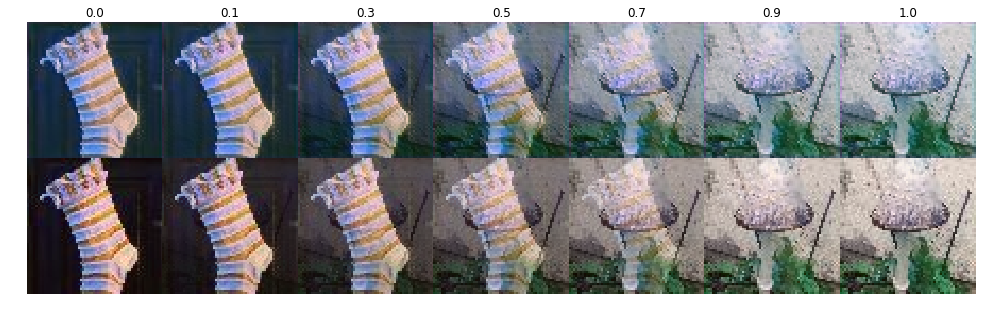

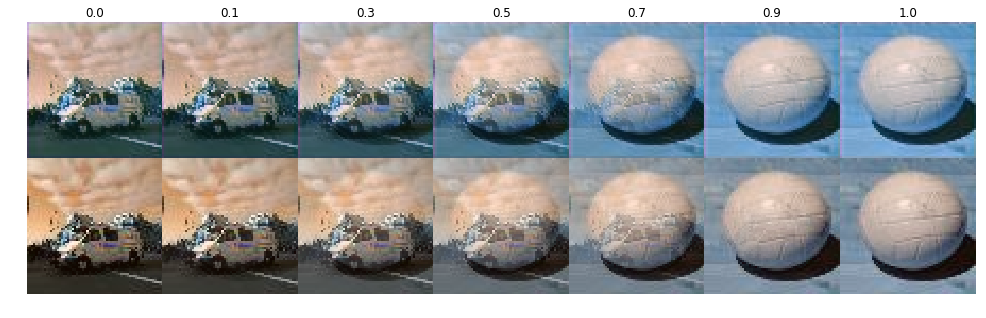

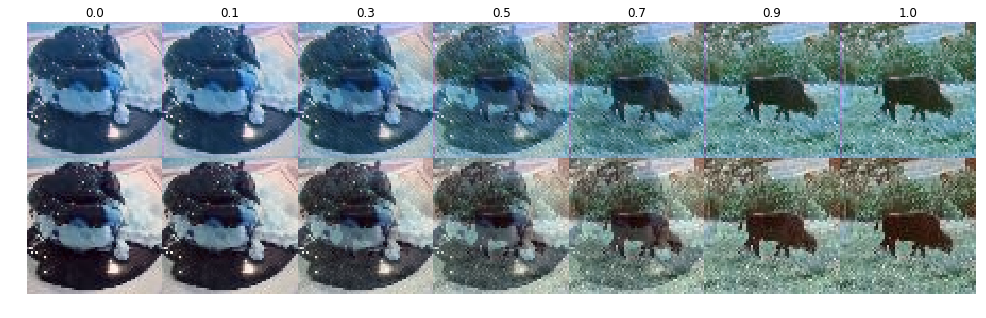

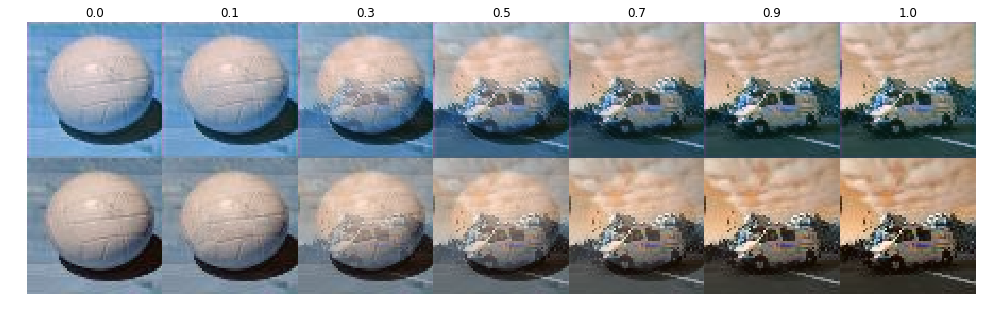

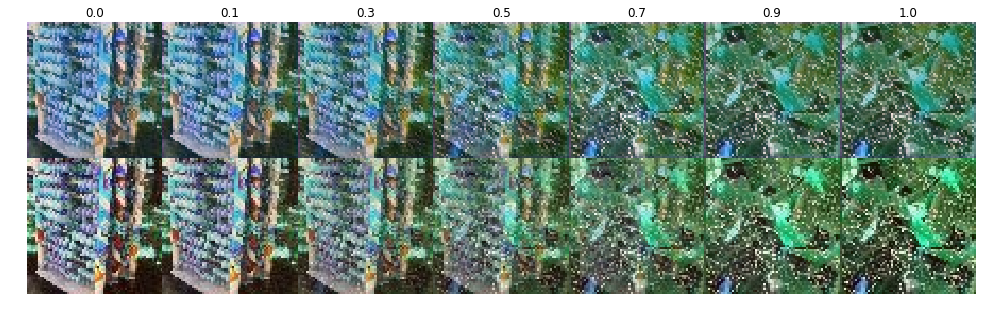

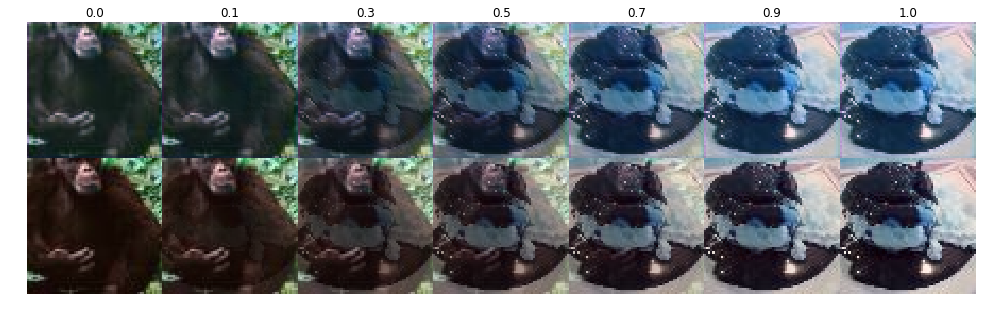

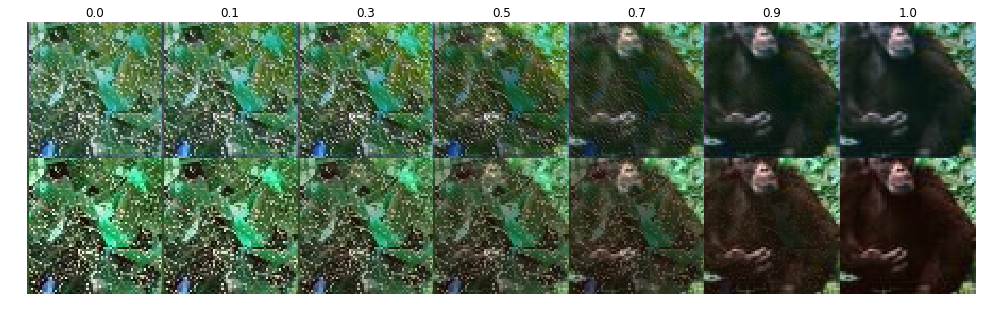

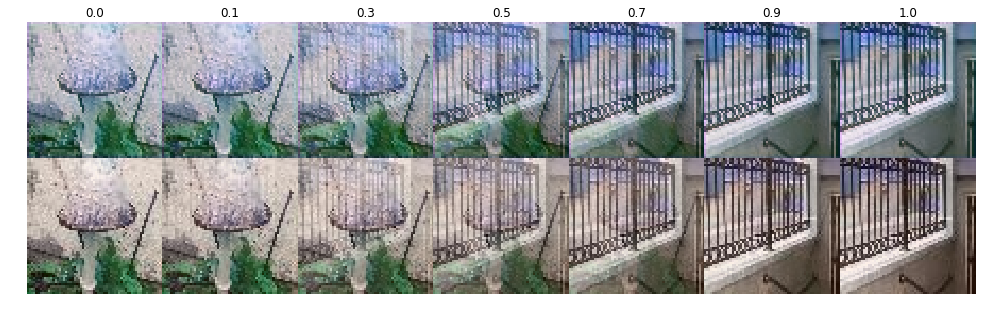

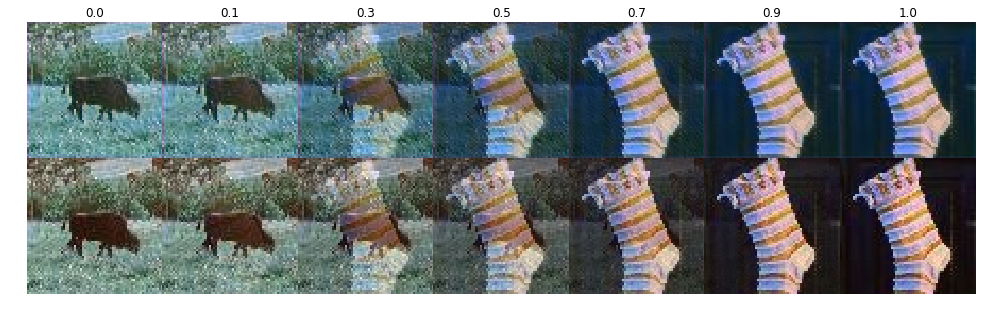

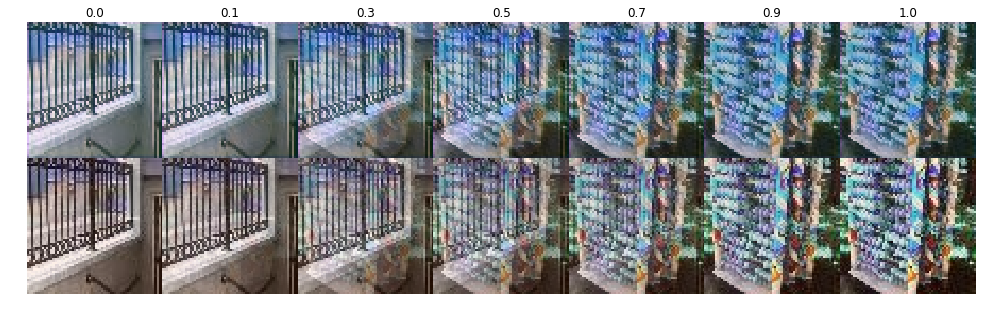

In [68]:
idList = [0, ]
# rList = torch.Tensor([0., 0.2, 0.5, 0.8, 1.]).to(device)
# rList = torch.Tensor([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]).to(device)
rList = [0., 0.1, 0.3, 0.5, 0.7, 0.9, 1.]
# rList = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
# rList = [0., 0.2, 0.4, 0.6, 0.8, 1.]
for i in range(10):
    automixResults = getResult(rList, 'automix', i)
    mixupResults = getResult(rList, 'mixup', i)
    myplot(automixResults, mixupResults, rList)

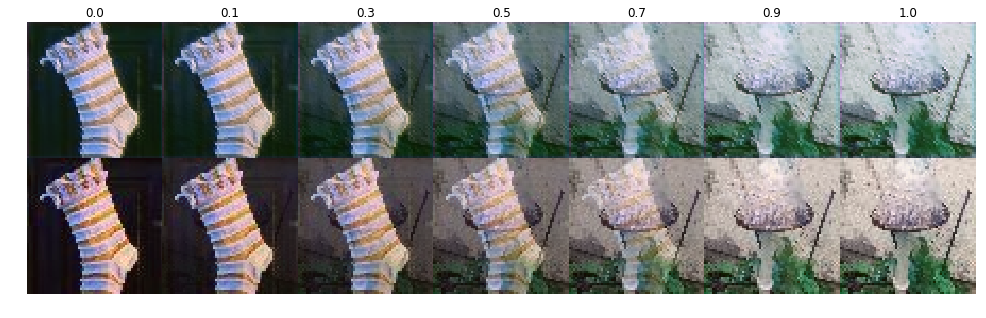

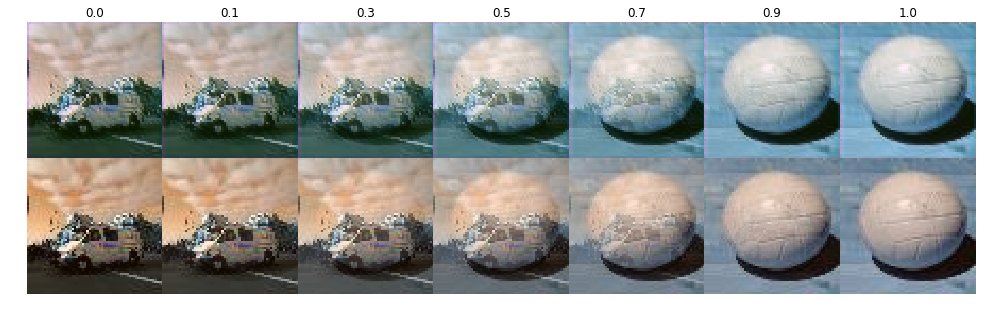

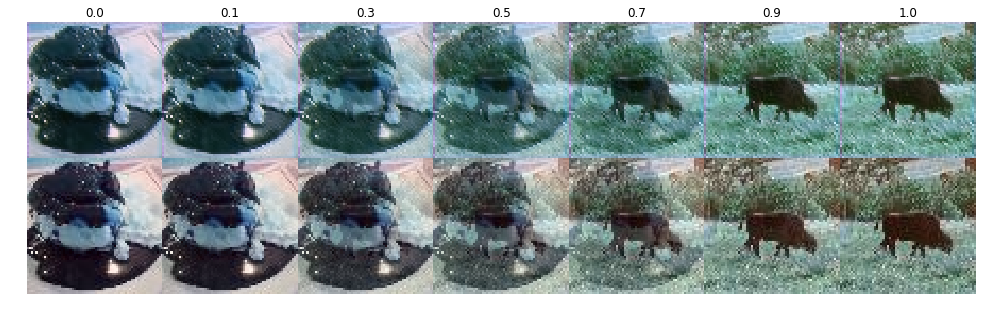

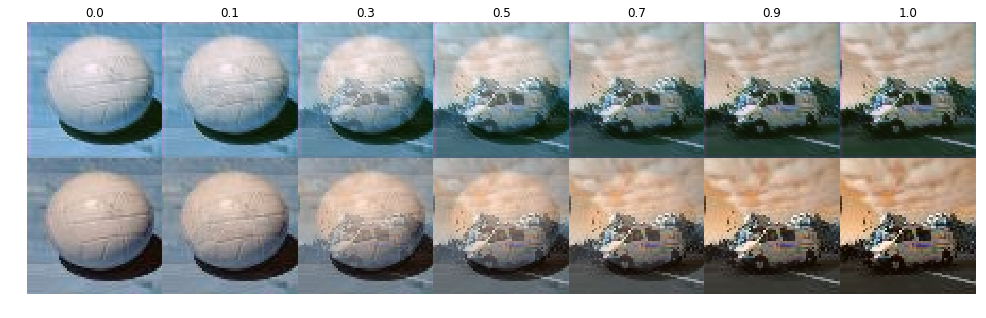

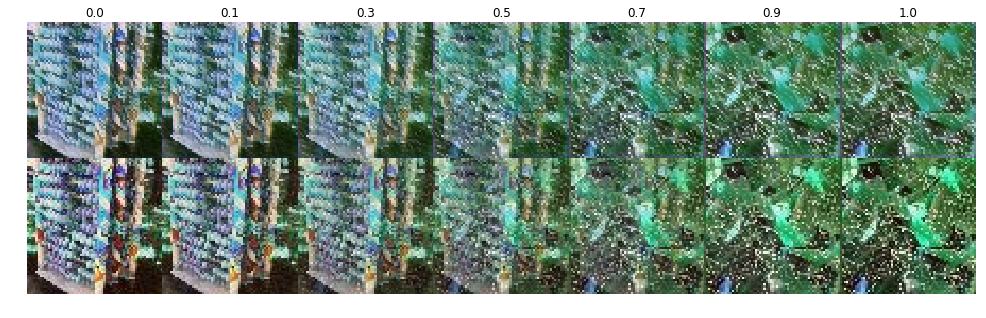

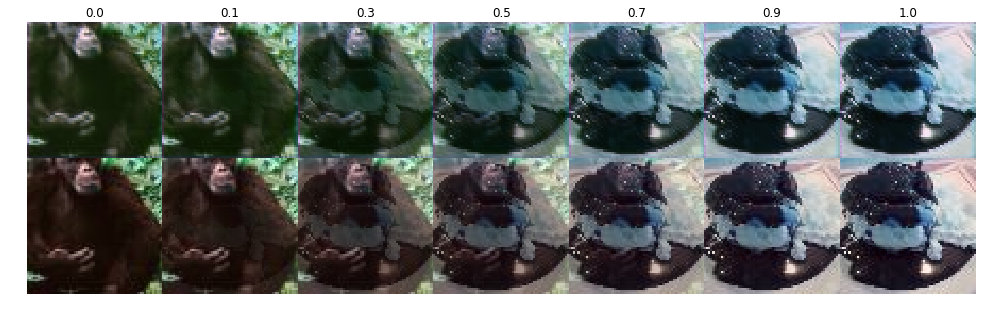

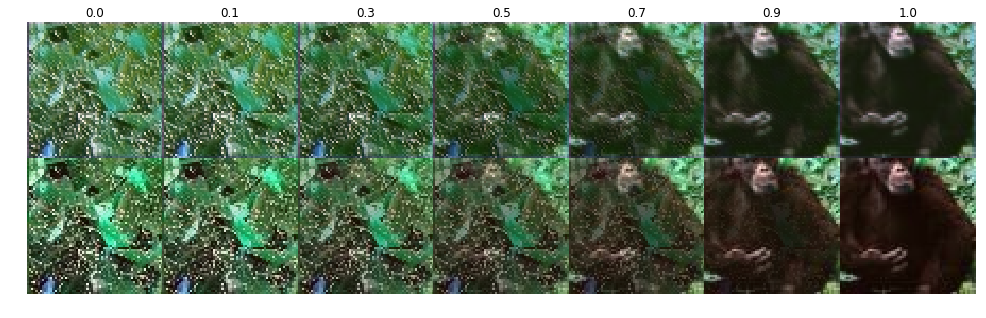

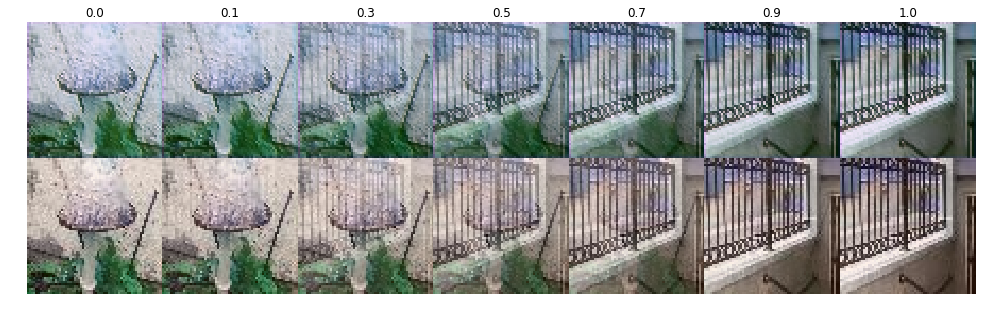

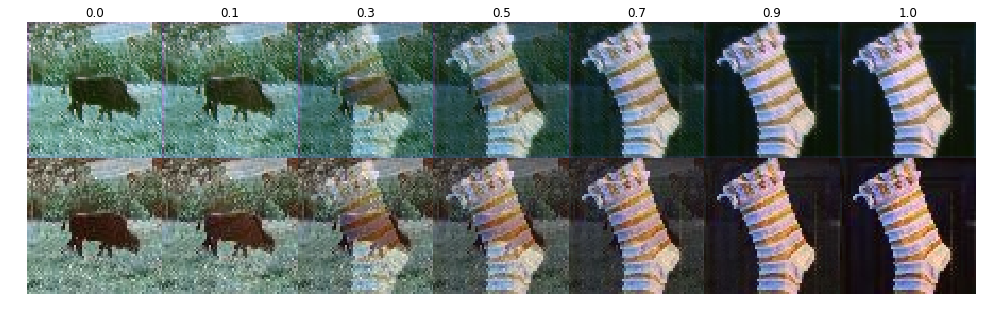

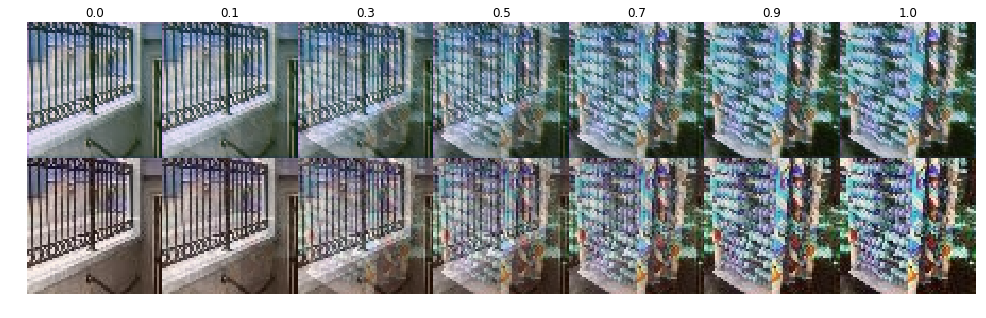

In [70]:
idList = [0, ]
# rList = torch.Tensor([0., 0.2, 0.5, 0.8, 1.]).to(device)
# rList = torch.Tensor([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]).to(device)
rList = [0., 0.1, 0.3, 0.5, 0.7, 0.9, 1.]
# rList = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
# rList = [0., 0.2, 0.4, 0.6, 0.8, 1.]
for i in range(10):
    automixResults = getResult(rList, 'automix', i)
    mixupResults = getResult(rList, 'mixup', i)
    myplot(automixResults, mixupResults, rList)

In [77]:
ll = [60.08, 60.1, 59.85, 60.88]
print('{}±{}'.format(100-np.mean(ll), np.std(ll)))

39.7725±0.38931831449342397


# OptTransMix

In [84]:
norm(images[0][0])

tensor([[0.0000, 0.0000, 0.9766,  ..., 0.9766, 0.9708, 0.9649],
        [0.0000, 0.0000, 0.9766,  ..., 0.9708, 0.9649, 0.9649],
        [0.0000, 0.0000, 0.9766,  ..., 0.9649, 0.9649, 0.9649],
        ...,
        [0.0000, 0.0000, 0.5965,  ..., 0.8889, 0.8889, 0.8947],
        [0.0000, 0.0000, 0.6374,  ..., 0.9123, 0.9181, 0.9181],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [29]:
def norm(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img

nb_images = 10

# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0))
v2 = np.array((0, 1))

f1 = norm(images[0].transpose(0, 1).transpose(1, 2).cpu().numpy())
f2 = norm(images2[0].transpose(0, 1).transpose(1, 2).cpu().numpy())
# images[0].transpose(0, 1).transpose(1, 2).cpu().numpy().mean()
# print(np.sum(f1, axis=(0, 1)))

duration : 1.1625909805297852
duration : 1.073575496673584
duration : 1.0213794708251953
duration : 1.2644383907318115
duration : 1.2095580101013184
duration : 1.1377980709075928


KeyboardInterrupt: 

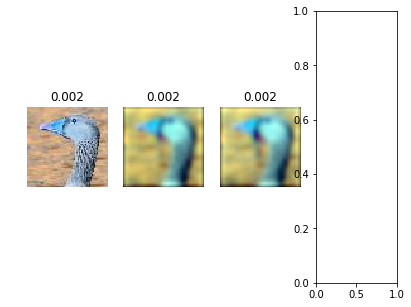

In [89]:
# regList = np.arange(0.005, 0.01, 0.001)
regList = [0.002, 0.0005, 0.0008, 0.001, 0.002]
for reg in regList:
    plt.figure(figsize=(17, 5))
#     plt.figure(figsize=(10, 10))
    plt.title('Convolutional Wasserstein Barycenters in POT')
    cm = 'Blues'
    # regularization parameter
#     reg = 0.002
    for i in range(nb_images):
        plt.subplot(1, nb_images, i + 1)
        tx = float(i) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        weights = (1-tx) * v1 + tx * v2

        if i == 0:
            plt.imshow(f1, cmap=cm)
            plt.axis('off')
        elif i == (nb_images - 1):
            plt.imshow(f2, cmap=cm)
            plt.axis('off')
        else:
            f1split = cv2.split(f1)
            f2split = cv2.split(f2)
            result = []
            for channel in [0, 1, 2]:
                img1 = f1split[channel]
                img2 = f2split[channel]
                img1 = img1 / np.sum(img1)
                img2 = img2 / np.sum(img2)
                A = []
                A.append(img1)
                A.append(img2)
                A = np.array(A)
                start = time.time()
                result.append(norm(ot.bregman.convolutional_barycenter2d(A, reg, weights)))
                print('duration : {}'.format(time.time() - start))
            result = cv2.merge(result)
            # call to barycenter computation
            plt.imshow(result, cmap=cm)
#             plt.imshow(np.transpose(result, (1, 2, 0)), cmap=cm)
            plt.axis('off')
        plt.title('{}'.format(reg))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.)
    plt.show()

In [151]:
a = torch.randn((20)).uniform_(0, 1)
r = 0.7
a

tensor([0.4485, 0.9733, 0.6850, 0.4905, 0.2102, 0.3793, 0.2056, 0.7571, 0.6034,
        0.1977, 0.3087, 0.7654, 0.7925, 0.5340, 0.4204, 0.3072, 0.7765, 0.5425,
        0.2815, 0.7757])

In [66]:
ones = torch.ones(round(a.shape[0]*r))
zeros = torch.zeros(round(a.shape[0]*(1-r)))
mask = torch.cat([ones, zeros])
print(mask.shape, mask)
ind = torch.randperm(len(mask))
mask = mask[ind]
print(mask)

torch.Size([20]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0.])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 1.])


In [152]:
torch.bernoulli(a)

tensor([0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        0., 1.])

In [84]:
a = torch.tensor((100., 10., 5.))
a.uniform_(0, 1)

tensor([0.3839, 0.2659, 0.1928])

In [85]:
torch.Tensor([1, 2, 3])

tensor([1., 2., 3.])

In [87]:
a = [[1, 2, 3, 4]]
b = [[3, 4, 5, 6]]
a+b

[[1, 2, 3, 4], [3, 4, 5, 6]]

In [88]:
a = [(0, 0), (1, 1), (2, -1)]

In [90]:
[x[0] for x in a]

[0, 1, 2]

In [104]:
list(set(np.arange(3)) - set([0, 1]))[0]

2

In [147]:
acc = {}
acc['mixup   '] = [x+1 for x in [59.96, 60.17, 60.09, 60.59, 60.40, 60.09, 60.22, 60.07, 60.24, 60.46]]
acc['baseline'] = [x+3 for x in [57.05, 56.53, 56.20, 56.76, 56.65, 56.75, 56.78, 56.92, 56.57, 56.26]]
acc['automix '] = [x+0.5 for x in [62.42, 62.39, 62.63, 62.22, 62.69, 62.11, 62.28, 61.80, 62.36, 62.62]]
acc['bc      '] = [x+1 for x in [60.10, 60.08, 59.85, 60.88, 60.46, 60.50, 60.18, 60.25, 60.26, 60.38]]
acc['manifold'] = [62.44, 62.47, 61.99, 62.89, 61.49, 62.34, 62.04, 61.67, 63.01, 62.19]

In [150]:
for method in acc.keys():
    a = acc[method]
    print('{} :\t{:.4f}±{:.4f}'.format(method, 100-np.mean(a), np.std(a)))

mixup    :	38.7710±0.1879
baseline :	40.3530±0.2544
automix  :	37.1480±0.2560
bc       :	38.7060±0.2679
manifold :	37.7470±0.4592
